# Frozen Functions

In this book, you will learn how to use Dr.Jit's `freeze` decorator to improve
the performance of rendering a complex scene.

%%[markdown]
First, we can import Mitsuba along with Dr.Jit and matplotlib. We also have to
tell Mitsuba, which variant we want to use. Depending on your system, your GPU
might not have enough VRAM. In that case, remove the "cuda_ad_rgb" variant.
To record accurate kernel timings, we also enable Dr.Jit's kernel history.

## Imports

In [1]:
import matplotlib.pyplot as plt
import mitsuba as mi
import drjit as dr
import time

mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

dr.set_flag(dr.JitFlag.KernelHistory, True)

## Rendering a Scene

Let's define a function that takes a scene as well as a seed, and renders the
scene with 1 sample per pixel. The seed can be either a Python `int`, or a Mitsuba
`mi.UInt32`. When changing a Python `int` in the arguments of a frozen function,
it would lead to the function being re-traced. Therefore, we use a `mi.UInt32` type.

In [2]:
def func(scene: mi.Scene, seed: mi.UInt32):
    return mi.render(scene, spp=1, seed=seed)

We can now load a complex scene. The bistro scene for example, contains many different
shapes and materials which have to be traced when to compile the kernel.

In [3]:
scene = mi.load_file("data/bistro/scene.xml")

2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:32 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:33 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03 14:13:33 WARN  [BitmapTexture] Image must be at least 2x2 pixels in size, up-sampling..
2025-07-03

Rendering the scene, can be expensive, as the following code shows.
We also measure the time, that the GPU spent executing kernels on the GPU, using
Dr.Jit's kernel history. In some applications, part of the tracing cost can
be hidden by kernel execution, if the code is designed in a way, that allows asynchronous
execution on the GPU.
We initialize the seed with `dr.opaque`, which will directly allocate and initialize
memory on the GPU. When freezing the function, this will reduce the number of
times the function has to be recorded before being able to replay it.

Rendering the bistro scene took 1.7049462795257568s
Executing the kernels took just 0.02336099209450185s


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

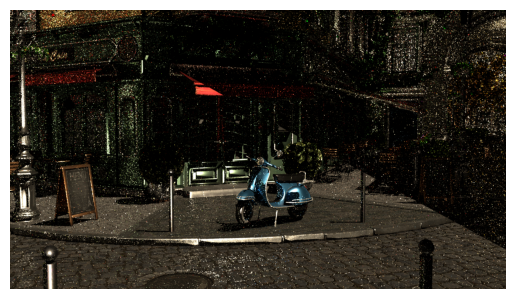

In [4]:
seed = dr.opaque(mi.UInt32, 0)

dr.kernel_history_clear()
start = time.time()
img = func(scene, seed)
dr.sync_thread()
end = time.time()

duration = end - start
# Kernel Execution time is stored in milliseconds
execution_time = (
    dr.sum([kernel["execution_time"] for kernel in dr.kernel_history()]) / 1000
)


print(f"Rendering the bistro scene took {duration}s")

print(f"Executing the kernels took just {execution_time}s")

plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis("off")

## Creating a Frozen Function

To use the frozen function decorator, we can either define a new function, that we annotate with `@dr.freeze`
```python
@dr.freeze
def frozen(scene: mi.Scene, seed: mi.UInt32):
    return mi.render(scene, spp=1, seed=seed)
```
or we can create a new frozen function instance from an existing function by calling

In [5]:
frozen = dr.freeze(func)

Multiple frozen functions can be created, referencing the same function. They
will all have their own separate recording cache.

Now we can call the frozen function, recording the kernels launched by `func`.
The first time this will take longer than calling the function directly, since
Dr.Jit has to traverse the inputs, record kernel calls, and construct outputs.

Rendering the scene while recording the frozen function took 4.247937202453613s


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

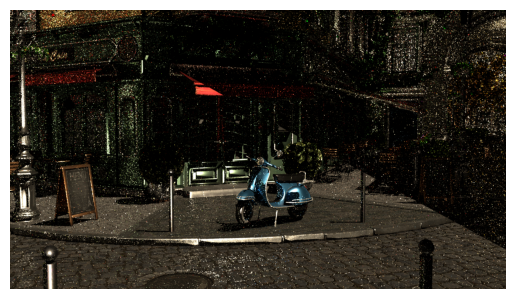

In [6]:
seed = dr.opaque(mi.UInt32, 0)

start = time.time()
img = frozen(scene, seed)
dr.sync_thread()
end = time.time()

print(f"Rendering the scene while recording the frozen function took {end - start}s")

plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis("off")

We can check, that the function has been recorded, and that the recording is
stored in the frozen function callable, using the `n_recordings` and `n_cached_recordings`
properties.

In [7]:
assert frozen.n_recordings == 1
assert frozen.n_cached_recordings == 1

Subsequent calls to the function will be faster, since the kernels are simply replayed,
after analyzing the inputs. Since we provided an opaque seed value, we are able
to change it, without having to re-trace the function. If it was initialized as
a literal (i.e. `seed = mi.UInt32(0)`), the second call would determine the literals
that changed, and make them opaque automatically (auto opaque feature). Subsequent
calls would then replay the function, without re-tracing it.

Rendering the scene while replaying the function took 0.10181283950805664s
Executing the kernels took 0.022070943478029223s


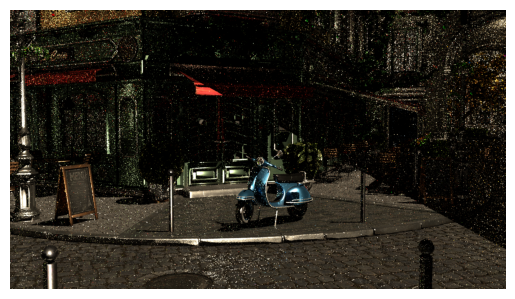

In [8]:
seed = dr.opaque(mi.UInt32, 1)

dr.kernel_history_clear()
start = time.time()
img = frozen(scene, seed)
dr.sync_thread()
end = time.time()

duration_frozen = end - start

# Kernel Execution time is stored in milliseconds
execution_time_frozen = (
    dr.sum([kernel["execution_time"] for kernel in dr.kernel_history()]) / 1000
)

print(f"Rendering the scene while replaying the function took {duration_frozen}s")

plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis("off")

print(f"Executing the kernels took {execution_time_frozen}s")

To verify, that the function has not been re-traced, we can again use `n_recordings`,
which gets incremented whenever the function is re-traced.

In [9]:
assert frozen.n_recordings == 1
assert frozen.n_cached_recordings == 1

## Results

Finally, we can plot a graph to visualize the performance gained by using frozen functions.

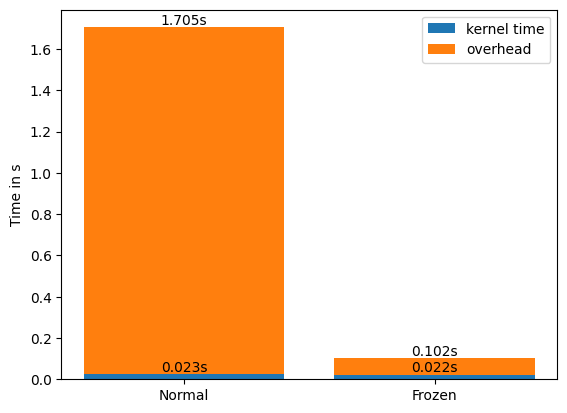

In [10]:
b = plt.bar(
    ["Normal", "Frozen"], [execution_time, execution_time_frozen], label="kernel time"
)
plt.bar_label(b, fmt="{:0.3f}s")
b = plt.bar(
    [0, 1],
    [duration - execution_time, duration_frozen - execution_time_frozen],
    bottom=[execution_time, execution_time_frozen],
    label="overhead",
)
plt.bar_label(b, fmt="{:0.3f}s")
plt.ylabel("Time in s")
plt.legend()